In [1]:
import pickle
import numpy as np
import pandas as pd
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
device = torch.device('cpu')

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
from torchsummary import summary
from torch.nn import functional as F

In [3]:
from src.genetic_generator import decode_bracket

# Подготовка данных

TODO: добавить glob, переместить все дампы в папку

In [4]:
files_x = sorted(glob.glob('dumps/dump_x*.pkl'))
files_y = sorted(glob.glob('dumps/dump_y*.pkl'))
print(f'{len(files_x)} files')

810 files


In [5]:
with open(files_x[0], 'rb') as fx, open(files_y[0], 'rb') as fy:
    data_x = np.array([decode_bracket(i)[0] for i in pickle.load(fx)])
    data_y = np.array([decode_bracket(i)[0] for i in pickle.load(fy)])
    assert data_x.shape == data_y.shape
    assert len(data_x.shape) == 3

files_x.pop(0)
files_y.pop(0)

for filename_x, filename_y in zip(files_x, files_y):
    with open(filename_x, 'rb') as fx, open(filename_y, 'rb') as fy:
        ex_data_x = np.array([decode_bracket(i)[0] for i in pickle.load(fx)])
        ex_data_y = np.array([decode_bracket(i)[0] for i in pickle.load(fy)])

        assert ex_data_x.shape == ex_data_y.shape, f'Broke: {ex_data_x}, {ex_data_y}, ex_data_x.shape == ex_data_y.shape: {ex_data_x.shape == ex_data_y.shape}'
        assert len(ex_data_x.shape) == 3

        data_x = np.vstack((data_x, ex_data_x))
        data_y = np.vstack((data_y, ex_data_y))

In [6]:
data_x_r = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2]))
data_y_r = data_y.reshape((data_y.shape[0], data_y.shape[1] * data_y.shape[2]))
swaps = []

for x, y in zip(data_x_r, data_y_r):
    swaps.append(np.where(x != y)[0])
swaps = np.array(swaps)
print(swaps)
assert swaps.shape[0] == data_x.shape[0]
assert swaps.shape[1] == 2

[[ 5  8]
 [56 69]
 [59 69]
 ...
 [34 38]
 [44 55]
 [45 55]]


In [7]:
X = torch.tensor(data_x_r.astype('float32'))
y = torch.tensor(swaps.astype('float32'))

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)
print(f'Train: {X.shape[0]}, test: {X_test.shape[0]}')

Train: 19510, test: 2168


# Полносвязная нейросеть

In [38]:
# TODO:
# test activation functions
# test architectures
# different optimizers 

In [10]:
model = nn.Sequential(
  nn.Linear(X.shape[1], X.shape[1]),
  nn.ReLU(),
  nn.Linear(X.shape[1], X.shape[1]),
  nn.ReLU(),
  nn.Linear(X.shape[1], X.shape[1]),
  nn.ReLU(),
  nn.Linear(X.shape[1], X.shape[1] // 4),  
  nn.ReLU(),
  nn.Linear(X.shape[1] // 4, 2),
  )
model.to(device)

Sequential(
  (0): Linear(in_features=70, out_features=70, bias=True)
  (1): ReLU()
  (2): Linear(in_features=70, out_features=70, bias=True)
  (3): ReLU()
  (4): Linear(in_features=70, out_features=70, bias=True)
  (5): ReLU()
  (6): Linear(in_features=70, out_features=17, bias=True)
  (7): ReLU()
  (8): Linear(in_features=17, out_features=2, bias=True)
)

In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
n_epochs = 100
batch_size = 200
history = []

In [12]:
for n_epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    
    print(f'Finished epoch {n_epoch + 1}/{n_epochs}, latest loss {loss:.3f}, R^2 on test {r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()):.3f}, NMSE on test {mean_squared_error(y_test.detach().numpy(), model(X_test).detach().floor().numpy()):.3}')

Finished epoch 1/100, latest loss 1502.338, R^2 on test -2.627, NMSE on test 1.46e+03
Finished epoch 2/100, latest loss 1314.386, R^2 on test -2.166, NMSE on test 1.27e+03
Finished epoch 3/100, latest loss 1159.766, R^2 on test -1.809, NMSE on test 1.13e+03
Finished epoch 4/100, latest loss 1032.555, R^2 on test -1.485, NMSE on test 9.97e+02
Finished epoch 5/100, latest loss 927.884, R^2 on test -1.252, NMSE on test 9.04e+02
Finished epoch 6/100, latest loss 841.750, R^2 on test -1.040, NMSE on test 8.19e+02
Finished epoch 7/100, latest loss 770.861, R^2 on test -0.847, NMSE on test 7.41e+02
Finished epoch 8/100, latest loss 712.512, R^2 on test -0.711, NMSE on test 6.87e+02
Finished epoch 9/100, latest loss 664.477, R^2 on test -0.553, NMSE on test 6.23e+02
Finished epoch 10/100, latest loss 624.927, R^2 on test -0.482, NMSE on test 5.95e+02
Finished epoch 11/100, latest loss 592.357, R^2 on test -0.381, NMSE on test 5.54e+02
Finished epoch 12/100, latest loss 565.531, R^2 on test -0.

In [14]:
torch.save(model.state_dict(), 'model_big_14.pkl')

In [15]:
model.load_state_dict(torch.load('model_big_14.pkl'))
model.eval()

Sequential(
  (0): Linear(in_features=70, out_features=70, bias=True)
  (1): ReLU()
  (2): Linear(in_features=70, out_features=70, bias=True)
  (3): ReLU()
  (4): Linear(in_features=70, out_features=70, bias=True)
  (5): ReLU()
  (6): Linear(in_features=70, out_features=17, bias=True)
  (7): ReLU()
  (8): Linear(in_features=17, out_features=2, bias=True)
)

In [13]:
round(r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()), 3)

-0.0

# Сверточная нейронка

Данные для нее не reshape'им

In [14]:
X = torch.tensor(data_x.astype('float32'))
X = X[:, None, :, :]
y = torch.tensor(swaps.astype('float32'))

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)
print(f'Train: {X.shape[0]}, test: {X_test.shape[0]}')

Train: 19510, test: 2168


In [15]:
X[0], y[0]

(tensor([[[ 8.,  9., 14., 13., 11., 10., 12.,  1.,  5.,  2.,  4.,  6.,  7.,  3.],
          [10.,  1.,  2.,  8.,  5., 12., 11.,  3., 13., 14.,  7.,  6.,  4.,  9.],
          [ 9., 10.,  5.,  7.,  1.,  6.,  8., 12., 11.,  4.,  2., 14.,  3., 13.],
          [ 6.,  5.,  3., 10., 12., 14.,  4.,  2.,  9., 13.,  1., 11.,  8.,  7.],
          [13.,  2., 11.,  6.,  8.,  5.,  3.,  1., 12., 10., 14.,  4.,  9.,  7.]]]),
 tensor([44., 51.]))

In [16]:
class ConvNetSwapAdviser(nn.Module):
    def __init__(self):
        super(ConvNetSwapAdviser, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(30, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        #x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
model = ConvNetSwapAdviser().to(device)

summary(model, (1, 14, 5))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
history = []
n_epochs = 150
batch_size = 30

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 6, 11, 2]             102
         MaxPool2d-2              [-1, 6, 5, 1]               0
            Linear-3                   [-1, 16]             496
            Linear-4                    [-1, 8]             136
            Linear-5                    [-1, 2]              18
Total params: 752
Trainable params: 752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [18]:
for n_epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]

        y_pred = model(Xbatch)
        
        ybatch = y[i:i+batch_size]

        loss = criterion(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    

    print(f'''Finished epoch {n_epoch + 1}/{n_epochs}, 
          latest loss {loss:.3f}, 
          R^2 on test {r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()):.3f}, 
          NMSE on test {mean_squared_error(y_test.detach().numpy(), model(X_test).detach().floor().numpy()):.3}''')

Finished epoch 1/150, 
          latest loss 662.514, 
          R^2 on test -0.214, 
          NMSE on test 4.96e+02
Finished epoch 2/150, 
          latest loss 546.718, 
          R^2 on test -0.009, 
          NMSE on test 4.12e+02
Finished epoch 3/150, 
          latest loss 545.230, 
          R^2 on test -0.007, 
          NMSE on test 4.12e+02
Finished epoch 4/150, 
          latest loss 545.144, 
          R^2 on test -0.007, 
          NMSE on test 4.11e+02
Finished epoch 5/150, 
          latest loss 545.136, 
          R^2 on test -0.007, 
          NMSE on test 4.12e+02
Finished epoch 6/150, 
          latest loss 545.135, 
          R^2 on test -0.007, 
          NMSE on test 4.12e+02
Finished epoch 7/150, 
          latest loss 545.145, 
          R^2 on test -0.007, 
          NMSE on test 4.12e+02
Finished epoch 8/150, 
          latest loss 545.152, 
          R^2 on test -0.007, 
          NMSE on test 4.12e+02
Finished epoch 9/150, 
          latest loss 545.164, 
 

KeyboardInterrupt: 

In [67]:
torch.save(model.state_dict(), 'model_conv_14_5_r2_-0.001.pkl')

In [74]:
y_pred_test = model(X_test).detach().floor().numpy()
y_test = y_test.numpy()

<Axes: >

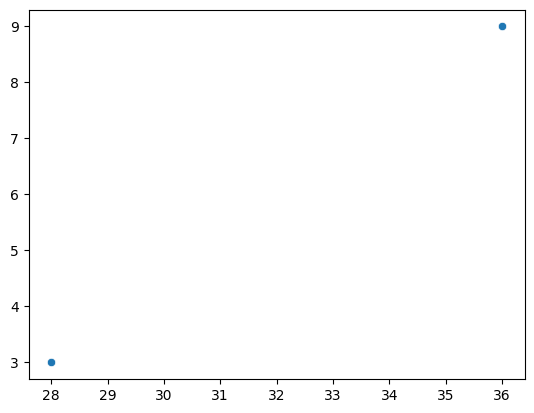

In [76]:
y_pred_test, y_test
import seaborn as sns
sns.scatterplot(x=, y=)